In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from loguru import logger
from functools import reduce

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
def create_heatmap(malla):
    # Calcular el conteo de cursos por nivel
    conteo = malla.groupby('nivel').size().reset_index(name='total')
    max_courses = malla.groupby('nivel')['sigla'].count().max()

    frames = []

    # Crear DataFrame adicional para rellenar con filas vacías
    for nivel in malla['nivel'].unique():
        valor = conteo.loc[conteo['nivel'] == nivel, 'total'].values[0]
        temp = pd.DataFrame(columns=malla.columns).sort_values(['nivel', 'sigla'])
        temp['nivel'] = [nivel] * (max_courses - valor)
        temp['sigla'] = ""
        frames.append(temp.fillna(0))

    df_extra = pd.concat(frames)
    malla_new = pd.concat([malla, df_extra])#.sort_values(['nivel', 'creditos'], ascending=[True, False])
    malla_new['enumeracion'] = malla_new.groupby('nivel').cumcount() + 1
    malla_new['nivel'] = malla_new['nivel'].astype(int)
    malla_new.loc[malla_new['aprobacion'] == '', 'aprobacion'] = 0

    # Crear una tabla pivote para el heatmap, llenando celdas vacías con NaN
    pivot_table = malla_new.pivot(index='enumeracion', columns='nivel', values='aprobacion').fillna(0)

    # Crear anotaciones personalizadas con siglas
    annotations = malla_new.pivot(index='enumeracion', columns='nivel', values='sigla')

    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot_table, annot=annotations, fmt='', cmap='Blues', cbar_kws={'label': 'Aprobacion'}, linewidths=0.5)
    ax.set_title('Heatmap de Aprobacion por Nivel y Sigla')
    ax.set_xlabel('Nivel')
    ax.set_ylabel('Enumeracion')

    plt.show()

In [3]:
def promedio_simple(df):
    notas = df['nota'].apply(lambda x:55+15*(x-4) ).astype(int)
    pd_series = pd.Series(round(notas.mean(),2),index=['PS'])
    return pd_series

def promedio_ponderado(df):
    notas = df['nota'].apply(lambda x:55+15*(x-4) ).astype(int)
    creditos = df['creditos'].copy()
    result = (notas*creditos).sum()/creditos.sum()
    pd_series = pd.Series(round(result,2),index=['PP'])
    return pd_series

def nota_credito(df):
    notas = df['nota'].copy()#.apply(lambda x:55+15*(x-4) ).astype(int)
    creditos = df['creditos'].copy()
    result = (notas*creditos).sum()
    pd_series = pd.Series(result,index=['NxCr'])
    return pd_series

def creditos_totales(df):
    result = df['creditos'].sum()
    pd_series = pd.Series(result,index=['CT'])
    return pd_series

def creditos_aprobados(df):
    result = df.loc[lambda x: x['estado_aprobacion']=='A']['creditos'].sum()
    pd_series = pd.Series(result,index=['CA'])
    return pd_series

def pa_directa(Ct,Ca,NxCr,S):
    numerador = NxCr*100*Ca
    denominador = 14*(S**1.06)*Ct
    
    return round(numerador/denominador)


def ramos_totales(df):
    pd_series = pd.Series(len(df),index=['RT'])
    return pd_series

def ramos_aprobados(df):
    result = df.loc[lambda x: x['estado_aprobacion']=='A']
    pd_series = pd.Series(len(result),index=['RA'])
    return pd_series

def resumen_estudiante(df):
    
    logger.info("informacion del estudiante")
    
    # estados 
    logger.info("estados")

    cols = ['rut','cohorte','nivel_alumno','ultimo_nivel','estado','estado_temporal']
    result_base = df.drop_duplicates(cols)[cols]
    result_base.columns = ['rut','cohorte','nivel_alumno','UN','EF','ET']
    
    # ramos
    logger.info("ramos")
    cols = ['rut','nivel_alumno']

    df_ramos_totales = df.groupby(cols).apply(ramos_totales).reset_index()
    df_ramos_aprobados = df.groupby(cols).apply(ramos_aprobados).reset_index()

    result_ramos = df_ramos_totales.merge(df_ramos_aprobados,on = cols)
    
    # creditos 
    logger.info("creditos")

    cols = ['rut','nivel_alumno']

    df_creditos_totales = df.groupby(cols).apply(creditos_totales).reset_index()
    df_creditos_totales['CTsum'] = df_creditos_totales.groupby('rut')['CT'].transform(lambda x: x.cumsum())

    df_creditos_aprobados = df.groupby(cols).apply(creditos_aprobados).reset_index()
    df_creditos_aprobados['CAsum'] = df_creditos_aprobados.groupby('rut')['CA'].transform(lambda x: x.cumsum())

    result_creditos = df_creditos_totales.merge(df_creditos_aprobados,on = cols)
    
    # notas
    logger.info("notas")

    cols = ['rut','nivel_alumno']
    df_nota_creditos = df.groupby(cols).apply(nota_credito).reset_index()
    df_nota_creditos['NxCrsum'] = df_nota_creditos.groupby('rut')['NxCr'].transform(lambda x: x.cumsum())

    df_promedio_simple = df.groupby(cols).apply(promedio_simple).reset_index()
    df_promedio_ponderado = df.groupby(cols).apply(promedio_ponderado).reset_index()

    result_notas = df_nota_creditos.merge(df_promedio_simple,on = cols).merge(df_promedio_ponderado,on = cols)
    
    # juntar informacion
    logger.info("juntar informacion")
    result = result_base.merge(result_ramos,on = cols)\
                    .merge(result_creditos,on = cols)\
                    .merge(result_notas,on = cols).rename(columns = {'nivel_alumno':'nivel'}).sort_values(['rut','nivel'])


    # informacion extra
    dct_estado = {
        'Desertor':'Desertor',
        'Eliminado':'Eliminado',
        'Titulado':'Matriculado',
        'Egresado':'Matriculado',
        'Matriculado':'Matriculado'
    }

    result['PA'] = result.apply(lambda x: pa_directa(x['CTsum'],x['CAsum'],x['NxCrsum'],x['nivel']), axis=1)
    result['N'] = 's' + result['nivel'].astype(str) + result['RT'].astype(str) + result['RA'].astype(str)
    result['NP'] = result.groupby('rut')['N'].shift().fillna('s0')

    result['EF'] = result['EF'].apply(lambda x: dct_estado[x])
    result['ET'] = result['ET'].apply(lambda x: dct_estado[x])

    result['PA_shift'] = result.groupby('rut')['PA'].shift()
    result['PA_diff'] = result['PA']-result['PA_shift']
    
    return result

In [4]:
logger.info("leer informacion")

path_data = '../data/'

logger.info("malla curricular")
malla = pd.read_csv(path_data + 'malla_anonimizados.csv',sep=',').fillna('')

malla.head()

2024-12-06 09:35:41.128 | INFO     | __main__:<module>:1 - leer informacion
2024-12-06 09:35:41.128 | INFO     | __main__:<module>:5 - malla curricular


,sigla,creditos,nivel,prerrequisitos,periodo_a_dictar,aprobacion,nivel_dependencia,departamento
0,curso_1,6,1,,0,81.70,8,depto_1
1,curso_2,6,1,,0,61.76,8,depto_1
2,curso_3,3,1,,1,71.59,7,depto_2
3,curso_4,4,2,curso_1,0,52.08,6,depto_1
4,curso_5,4,2,curso_2,0,59.38,7,depto_1


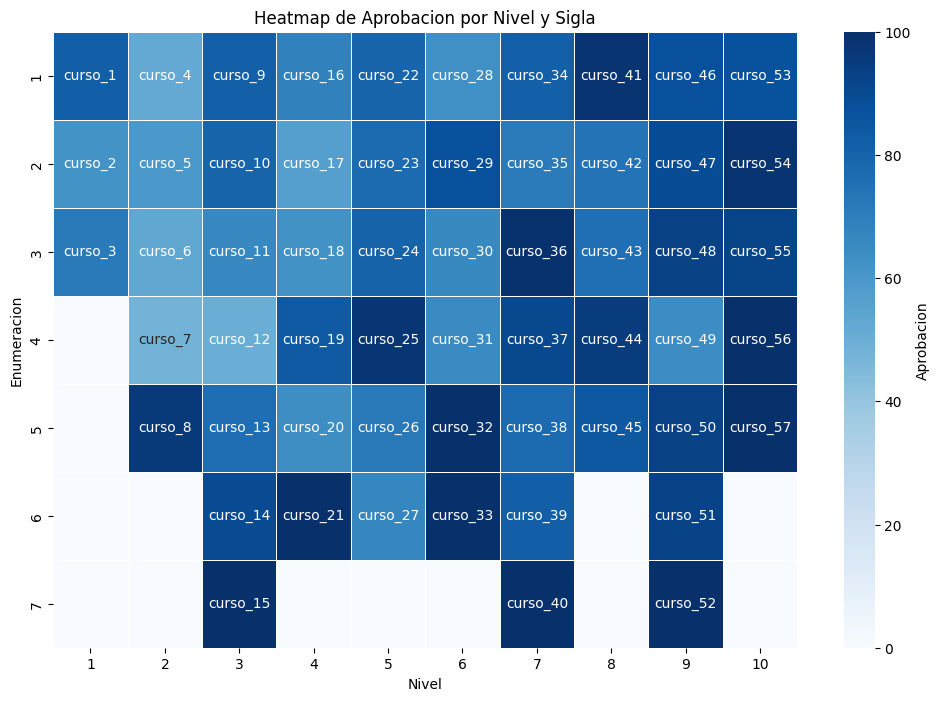

In [5]:
# heat map
create_heatmap(malla)

In [6]:
# alumnos en la carrera
logger.info("informacion notas universitarias")

df = pd.read_csv(path_data + 'datos_durante_anonimizados.csv',sep=',').rename(columns = {'ingreso':'cohorte'})
df['estado_aprobacion'] = df['estado_aprobacion'].str.replace('APRUEBA','A').str.replace('REPRUEBA','R')

df.head()

2024-12-06 09:35:41.473 | INFO     | __main__:<module>:2 - informacion notas universitarias


,rut,cohorte,estado,sigla,creditos,nivel_original,nivel_alumno,nota,oportunidad,estado_aprobacion,max_semestres,label,ultimo_nivel,estado_temporal
0,346,2011,Desertor,curso_2,6,1,-1,0,NaN,NaN,14,desercion_antes_1s,-1,Desertor
1,346,2011,Desertor,curso_1,6,1,-1,0,NaN,NaN,14,desercion_antes_1s,-1,Desertor
2,346,2011,Desertor,curso_3,3,1,-1,0,NaN,NaN,14,desercion_antes_1s,-1,Desertor
3,385,2011,Desertor,curso_2,6,1,-1,0,NaN,NaN,14,desercion_antes_1s,-1,Desertor
4,385,2011,Desertor,curso_1,6,1,-1,0,NaN,NaN,14,desercion_antes_1s,-1,Desertor


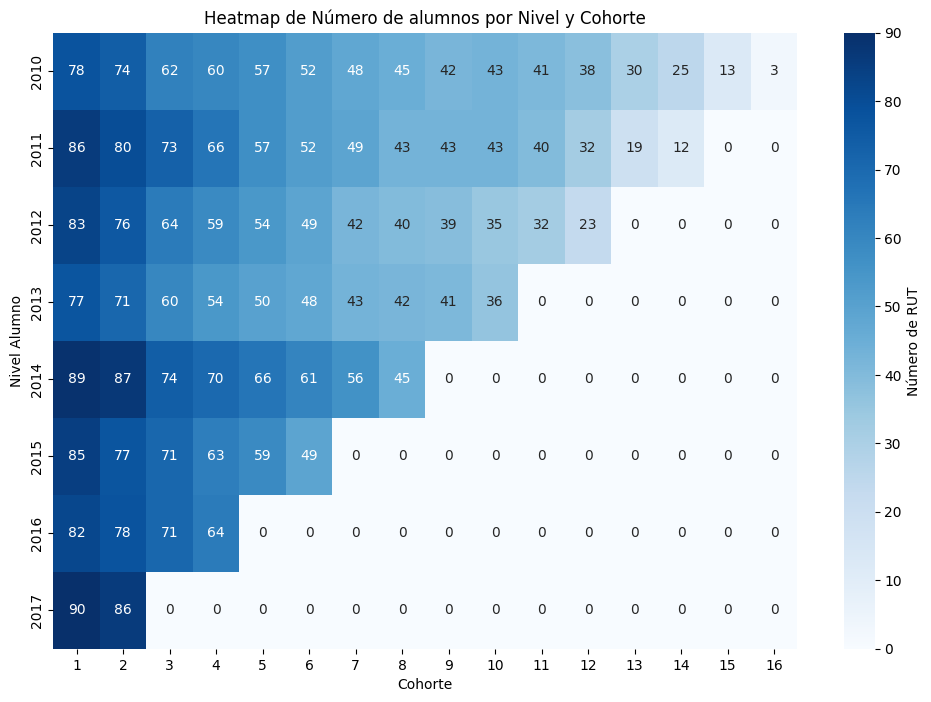

In [7]:
def create_rut_heatmap(df):
    # Agrupar por 'nivel_alumno' y 'cohorte' y contar los 'rut' únicos
    grouped = df.loc[lambda x: x['nivel_alumno']>0].groupby(['nivel_alumno', 'cohorte'])['rut'].nunique().reset_index()

    # Crear una tabla pivote para el heatmap
    pivot_table = grouped.pivot(index='cohorte', columns='nivel_alumno', values='rut').fillna(0)

    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot_table, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Número de RUT'})
    ax.set_title('Heatmap de Número de alumnos por Nivel y Cohorte')
    ax.set_xlabel('Cohorte')
    ax.set_ylabel('Nivel Alumno')

    plt.show()

# Llamar a la función para crear el heatmap
create_rut_heatmap(df)

In [8]:
logger.info("datos validos")
df_valido = df.loc[lambda x: x.label =='validos']

logger.info("resumen estudiante 2017-2018")
result = resumen_estudiante(df_valido)
result.head()

2024-12-06 09:35:41.755 | INFO     | __main__:<module>:1 - datos validos
2024-12-06 09:35:41.758 | INFO     | __main__:<module>:4 - resumen estudiante 2017-2018
2024-12-06 09:35:41.759 | INFO     | __main__:resumen_estudiante:48 - informacion del estudiante
2024-12-06 09:35:41.760 | INFO     | __main__:resumen_estudiante:51 - estados
2024-12-06 09:35:41.765 | INFO     | __main__:resumen_estudiante:58 - ramos
2024-12-06 09:35:42.905 | INFO     | __main__:resumen_estudiante:67 - creditos
2024-12-06 09:35:44.368 | INFO     | __main__:resumen_estudiante:80 - notas
2024-12-06 09:35:46.771 | INFO     | __main__:resumen_estudiante:92 - juntar informacion


,rut,cohorte,nivel,UN,EF,ET,RT,RA,CT,CTsum,...,CAsum,NxCr,NxCrsum,PS,PP,PA,N,NP,PA_shift,PA_diff
258,1,2010,1,15,Matriculado,Matriculado,3,3,15,15,...,15,927,927,930.0,922.00,6621,s133,s0,NaN,NaN
259,1,2010,2,15,Matriculado,Matriculado,5,4,18,33,...,29,1051,1978,886.0,870.83,5955,s254,s133,6621.0,-666.0
260,1,2010,3,15,Matriculado,Matriculado,4,4,12,45,...,41,742,2720,940.0,922.50,5524,s344,s254,5955.0,-431.0
261,1,2010,4,15,Matriculado,Matriculado,6,3,24,69,...,53,1308,4028,815.0,812.50,5084,s463,s344,5524.0,-440.0
262,1,2010,5,15,Matriculado,Matriculado,5,1,18,87,...,57,836,4864,685.0,691.67,4133,s551,s463,5084.0,-951.0


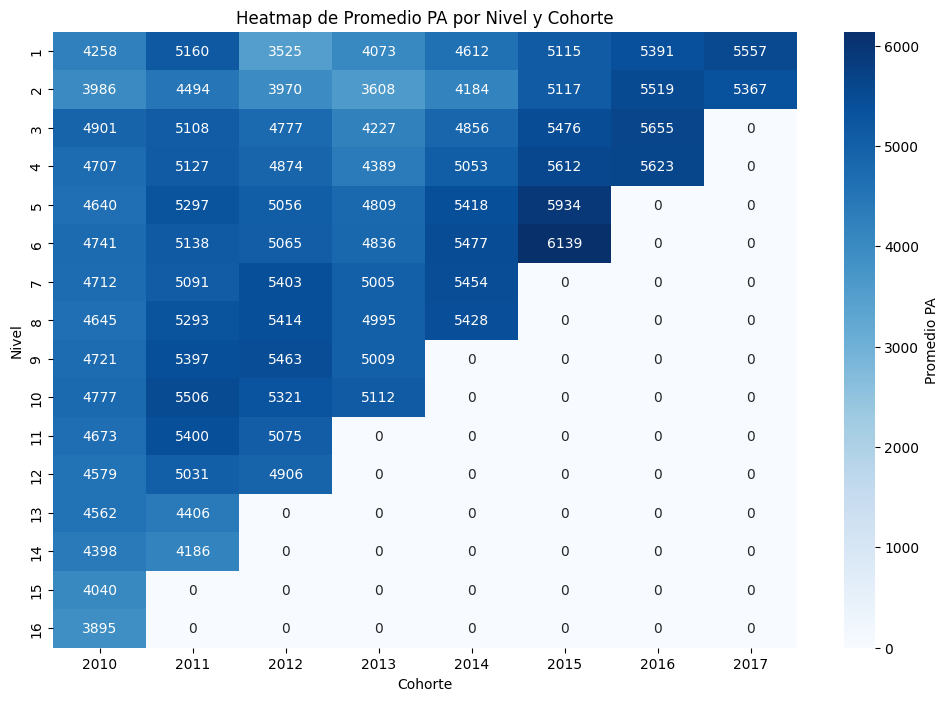

In [9]:
def create_pa_heatmap(df):
    # Agrupar por 'nivel' y 'cohorte' y calcular el promedio de 'PA'
    grouped = df.groupby(['nivel', 'cohorte'])['PA'].mean().reset_index()

    # Crear una tabla pivote para el heatmap
    pivot_table = grouped.pivot(index='nivel', columns='cohorte', values='PA').fillna(0)

    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Promedio PA'})
    ax.set_title('Heatmap de Promedio PA por Nivel y Cohorte')
    ax.set_xlabel('Cohorte')
    ax.set_ylabel('Nivel')

    plt.show()

# Llamar a la función para crear el heatmap
create_pa_heatmap(result)